In [1]:
# Import packages
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy, sigmoid_derivative, gradient_update, get_loss_plot, plot_loss
from helpers import sgd_with_momentum_update
import numpy as np

In [2]:
def prep_data(data_path):
    '''
    --------------------
    Prepare data
    Use vectorized flatten
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Load
    X_train, y_train, X_dev, y_dev, X_test, y_test = load_all_data(data_path)
    
    # Flatten
    X_train_flattened = vectorized_flatten(X_train)
    X_dev_flattened = vectorized_flatten(X_dev)
    X_test_flattened = vectorized_flatten(X_test)
    
    # Reshape labels
    y_train = y_train.reshape(1, -1)
    y_dev = y_dev.reshape(1, -1)
    y_test = y_test.reshape(1, -1)
    
    # Return
    return(X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test)

In [3]:
def initialize(X): 
    '''
    --------------------
    Parameter Initialization
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X [n = 12000])
    --------------------
    Output: 
    weights: Weight terms initialized as random normals
    biases: Bias terms initialized to zero
    --------------------
    '''
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(1, h1)
    
    b1 = np.zeros((h1, 1))
    b2 = np.zeros((1, 1))
    
    weights = (W1, W2)
    biases = (b1, b2)
    
    return weights, biases

In [4]:
def forward_pass(X, weights, biases):
    '''
    ----------------------------------
    Forward propogation:
    Send inputs through the network to
    generate output
    ----------------------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    weights: Binary (1/0) training label (shape = n X 1)
    biases:
    --------------------
    Output: 
    activations: vector of results from passing
    inputs through each neuron
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    
    activations = (z1, a1, z2, a2)
    
    return activations

In [5]:
def backpropagation(X, y, weights, biases, activations):
    '''
    --------------------
    Backpropagation
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = 784 X n)
    y: Binary (1/0) training label (shape = n X 1)
    weights: Current set of weights
    biases: Current set of biases
    activations: Current set of activations
    --------------------
    Output: 
    Derivatives required
    for optimization update
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    z1, a1, z2, a2 = activations
    m = y.shape[1]
    #print(m)   
    dz2 = a2 - y
    #print("dz3", dz3.shape)
    
   
    dW2 = np.dot(dz2, a1.T)/m
    #print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)/m
    #print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    #print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    #print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)/m
    #print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)/m
    #print("db1", db1.shape)
    
    return db1, dW1, db2, dW2

In [6]:
def update_parameters(weights, biases, gradients, learning_rate):
    '''
    --------------------
    Update parameters
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    db1, dW1, db2, dW2 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    
    weights = (W1, W2)
    biases = (b1, b2)
    
    return weights, biases

In [7]:
def update_parameters_with_momentum(weights,biases,gradients,learning_rate,velocity,momentum):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    
    db1, dW1, db2, dW2 = gradients
    vw1,vw2,vb1,vb2 = velocity
    W1,vw1 = sgd_with_momentum_update(W1, learning_rate, dW1,vw1,momentum)
    W2,vw2 = sgd_with_momentum_update(W2, learning_rate, dW2,vw2,momentum)
   
    b1,vb1 = sgd_with_momentum_update(b1, learning_rate, db1,vb1,momentum)
    b2,vb2 = sgd_with_momentum_update(b2, learning_rate, db2,vb2,momentum)
    
    weights = (W1, W2)
    biases = (b1, b2)
    velocity = (vw1,vw2,vb1,vb2)
    return weights ,biases,velocity

In [8]:
def batch_training_without_momentum(batch_size, weights, biases, epochs, lr, X, y):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    history = {
    "weights": [weights],
    "losses": [], 
    "biases": [biases],
    "accuracies": []
    
    }
    
    offset = 0
    
    for epoch in range(epochs):
        
        offset = 0
        weights = history['weights'][epoch]
        biases = history['biases'][epoch]
        
        while offset < max(y.shape):
            
            if offset%1000==0 :
                print("epoch :",epoch," batch:",offset)
            else :
                a=1
            if offset+batch_size >=max(y.shape):
                X_batch = X[:,offset:]
                y_batch = y[:,offset:]
            else :    
                X_batch = X[:,offset:offset+batch_size]
                y_batch = y[:,offset:offset+batch_size]
            
            
            activations = forward_pass(X_batch, weights, biases)
            gradients = backpropagation(X_batch, y_batch, weights, biases, activations)

            weights, biases = update_parameters(weights, biases, gradients, lr)
            offset = offset+batch_size
        
        activations_full = forward_pass(X, weights, biases)
        y_prob = activations_full[-1]
        y_pred = np.where(y_prob > 0.5, 1, 0)
    
        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)

        history["weights"].append(weights)
        history["losses"].append(loss)
        history["biases"].append(biases)
        history["accuracies"].append(accuracy)

        if np.isnan(loss):
            break

        print("loss after epoch: ",epoch,": ",loss)
    
    return history

In [9]:
def initialize_velocity(weights,biases):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2 = weights
    b1, b2 = biases
    vw1 = np.zeros(W1.shape)
    vw2 = np.zeros(W2.shape)
    vb1 = np.zeros(b1.shape)
    vb2 = np.zeros(b2.shape)
    return vw1,vw2,vb1,vb2

In [10]:
def batch_training_with_momentum(batch_size,weights,biases,history,X,y,momentum,lr,X_dev,y_dev):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    
    history = {
        "weights": [weights],
        "losses": [], 
        "biases": [biases],
        "accuracies": [],
        "velocity":[velocity],
        "dev_accuracies" :[],
        "dev_loss":[]
    }
    
    offset = 0
    
    for epoch in range(epochs):
        
        offset = 0
        weights = history['weights'][epoch]
        biases = history['biases'][epoch]
        velocity = history['velocity'][epoch]
        
        while offset <max(y_train.shape):
            if offset%1000==0 :
                print("epoch :",epoch," batch:",offset)
            else :
                a=1
            if offset+batch_size >=max(y_train.shape):
                X_batch = X[:,offset:]
                y_batch = y[:,offset:]
            else :    
                X_batch = X[:,offset:offset+batch_size]
                y_batch = y[:,offset:offset+batch_size]
            
            activations = forward_pass(X_batch, weights, biases)
            gradients = backpropagation(X_batch, y_batch, weights, biases, activations)

            
            weights, biases,velocity = update_parameters_with_momentum(weights, biases, gradients, 
                                                                       lr,velocity,momentum)
            offset = offset+batch_size
        
        activations_full = forward_pass(X, weights, biases)
        y_prob = activations_full[-1]
        y_pred = np.where(y_prob > 0.5, 1, 0)

        #print(y,y_prob)
        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)
        
        activations_dev = forward_pass(X_dev,weights,biases)
        y_dev_prob =  activations_dev[-1]
        y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)
        loss_dev = get_log_loss(y_dev,y_dev_prob)
        accuracy_dev = get_accuracy(y_dev,y_dev_pred)

        history["weights"].append(weights)
        history["losses"].append(loss)
        history["biases"].append(biases)
        history["velocity"].append(velocity)
        history["accuracies"].append(accuracy)
        history["dev_accuracies"].append(accuracy_dev)
        history['dev_loss'].append(loss_dev)

        if np.isnan(loss):
            break

        print("loss after epoch: ",epoch,": ",loss)
    return history

In [11]:
def get_best_epoch(history):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Store results
    best_epoch = np.array(history["losses"]).argmin()
    best_accuracy = history['accuracies'][best_epoch]
    best_loss = history['losses'][best_epoch]
    
    # Display results
    print(f"best accuracy: {history['accuracies'][best_epoch]}")
    print(f"best loss: {history['losses'][best_epoch]}")
    print(f"best epoch: {best_epoch}")
    
    return(best_epoch, best_accuracy, best_loss)

In [12]:
def get_results(X_dev, y_dev, history, best_epoch, label="dev"):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    w = history["weights"][best_epoch]
    b = history["biases"][best_epoch]
    activations = forward_pass(X_dev, w, b)

    y_dev_prob = activations[-1]
    y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)

    loss = get_log_loss(y_dev, y_dev_prob)
    accuracy = get_accuracy(y_dev, y_dev_pred)
    print(f"{label} set accuracy: {accuracy}")
    
    return(accuracy)

In [19]:
def run_training(data_path, epochs, model_name, h1, lr, mode, batch_size):
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    # Set seed for reproducible results
    np.random.seed(1252908)
    
    # Get data
    X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test = prep_data(data_path)
    
    # Assign batch size
    # If a batch size parameter is specified we use that otherwise we default to full batch gradient descent
    if mode == 'full': batch_size = max(y_train.shape)
    elif mode == 'stochastic': batch_size = 1
        
    print("The batch size is...{}".format(batch_size))

    # Initialize weights and biases
    weights, biases = initialize(X_train_flattened)
    
    # Enter training loop
    history = batch_training_without_momentum(batch_size, weights, biases, epochs, lr, X_train_flattened, y_train)
    
    # Get best epoch from history object
    best_epoch = get_best_epoch(history)
    
    # Plot loss and save
    plot_loss("loss_{}.png".format(model_name), history["losses"][:-2])
    
    # Plot accuracy and save
    plot_loss("accuracy_{}.png".format(model_name), history["accuracies"][:-2], label='Training Accuracy')
    
    return(history, best_epoch)

The batch size is...10
epoch : 0  batch: 0
epoch : 0  batch: 1000
epoch : 0  batch: 2000
epoch : 0  batch: 3000
epoch : 0  batch: 4000
epoch : 0  batch: 5000
epoch : 0  batch: 6000
epoch : 0  batch: 7000
epoch : 0  batch: 8000
epoch : 0  batch: 9000
epoch : 0  batch: 10000
epoch : 0  batch: 11000
loss after epoch:  0 :  1447.3387075541198
epoch : 1  batch: 0
epoch : 1  batch: 1000
epoch : 1  batch: 2000
epoch : 1  batch: 3000
epoch : 1  batch: 4000
epoch : 1  batch: 5000
epoch : 1  batch: 6000
epoch : 1  batch: 7000
epoch : 1  batch: 8000
epoch : 1  batch: 9000
epoch : 1  batch: 10000
epoch : 1  batch: 11000
loss after epoch:  1 :  1196.5432035333915
epoch : 2  batch: 0
epoch : 2  batch: 1000
epoch : 2  batch: 2000
epoch : 2  batch: 3000
epoch : 2  batch: 4000
epoch : 2  batch: 5000
epoch : 2  batch: 6000
epoch : 2  batch: 7000
epoch : 2  batch: 8000
epoch : 2  batch: 9000
epoch : 2  batch: 10000
epoch : 2  batch: 11000
loss after epoch:  2 :  1051.8023216287245
epoch : 3  batch: 0
epo

({'weights': [(array([[ 0.01619872,  0.01801601, -0.03417228, ..., -0.04823096,
            -0.05604477,  0.00901734],
           [ 0.01149911,  0.01923254, -0.02097324, ..., -0.03188668,
            -0.00640128,  0.07425657],
           [ 0.01154735,  0.01350113, -0.00265027, ...,  0.09964181,
             0.01167598,  0.00294111],
           ...,
           [-0.00108249,  0.00230341,  0.02563485, ...,  0.0009959 ,
             0.02456301,  0.01430508],
           [ 0.01832175,  0.00118309, -0.03305243, ..., -0.005914  ,
            -0.03218962,  0.07038516],
           [-0.00086598,  0.05116875,  0.08850713, ...,  0.01915647,
             0.02992496,  0.02984515]]),
    array([[-0.01311009, -0.06386502, -0.01692045, -0.00956199, -0.03516135,
             0.02304771,  0.00525049, -0.02400982,  0.02400189,  0.09434391,
             0.03044473, -0.02063809, -0.01385631, -0.08354234, -0.01564368,
            -0.01535444, -0.0118825 ,  0.03852521,  0.01543301, -0.01806274,
            -0.

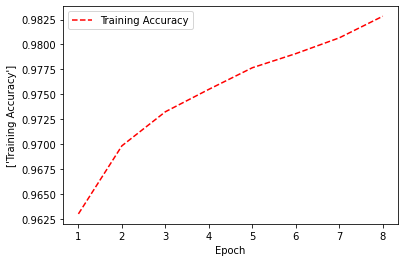

In [20]:
# Set path to data
data_path = '../setup/data'
epochs = 10
model_name = 'full_batch_without_momentum'
h1 = 32
lr = 0.1
batch_size = 10
mode = "full"


run_training(data_path, epochs, model_name, h1, lr, mode, batch_size)

# 3.4.2 Hyperparameter tuning using gridsearch

In [ ]:
def grid_search(momentum, lr, batch_size):


    best_params = {}
    best_params['loss'] = np.inf
    best_params['momentum'] = 0
    best_params['lr'] = 0
    best_params['batch_size'] = 0
    best_params["weights"] = 0
    best_params["biases"] = 0
    
    for m in momentum :
        for l in lr :
            for bs in batch_size :
                
                weights, biases = initialize(X_train_flattened)
                epochs = 50
                velocity = initialize_velocity(weights,biases)
                
                history = {
                    "weights": [weights],
                    "losses": [], 
                    "biases": [biases],
                    "accuracies": [],
                    "velocity":[velocity]
                }
                
                history = batch_training_with_momentum(bs,weights,biases,history,X_train_flattened,y_train,m,l)
                best_epoch = get_best_results(history)
                print(history['accuracies'][best_epoch],best_epoch)
                
                activations_dev = forward_pass(X_dev_flattened, history["weights"][best_epoch], history["biases"][best_epoch])
                y_prob = activations_dev[-1]
                dev_loss = get_log_loss(y_dev,y_prob)
                
                if dev_loss < best_params['loss'] :
                    best_params['momentum'] = m
                    best_params['lr'] = l
                    best_params['batch_size'] = bs
                    best_params['loss'] = dev_loss
                    best_params["weights"] = history["weights"][best_epoch]
                    best_params["biases"] = history["biases"][best_epoch]
            
    return(best_params)           

In [ ]:
# Store initial parameters
h1 = 32
lr = 0.1

In [ ]:
# Run training loops

In [ ]:
# Store grids for grid search
momentum = np.arange(0.001,0.01,0.001)
lr = np.arange(0.01,0.1,0.01)
batch_size = [16,64,256,1024,4096]

In [ ]:
# Run grid search and get best parameters

In [ ]:
# Train with the best parameters
history = execute_pipeline(**best_params)
plot_loss("loss.png", history["dev_loss"][:-2],label = "validation loss")
plot_loss("accuracy.png", history["dev_accuracies"][:-2], label='validation Accuracy')
history["dev_accuracies"]